 #                                                     üöó Predictive Maintenance for Flat Tire Detection üöó

### Problem Statement : Project Data Science / Analytics ( UFO Platform Defect Recognition )
The aim of this project is to identify sensor features that can effectively track the condition of rear tires, specifically focusing on flat tires (left or right). The main objective is to leverage this information for implementing Predictive Maintenance for Test Equipment on driving platforms (UFOpro).

In [1]:
# Info Provided by the Domain Expert regarding the Dataset and also the target variables. 
# UFO_test_combined
# Project Tire: "./UFO_project_flat_tire_rear.parquet"
# UFO OK = UFO1_736 - UFO1_747
# Flat Tire Rear Left = UFO1_748 - 757
# 758, 759 -> Fehlversuche
# Flat Tire Rear Right = UFO1_760 - UFO1_770
# Flat Tire Rear Right, Strong Flat Tire Rear Left = UFO1_771 - UFO1_782

In [2]:
# Importing necessary libraries for data analysis and visualization

import pandas as pd  # pandas is used for data manipulation and analysis. It provides DataFrame and Series objects.
import numpy as np  # numpy is used for numerical operations and handling arrays.
import re  # re provides support for working with regular expressions, which is useful for text cleaning and processing.
import matplotlib.pyplot as plt  # matplotlib.pyplot is a plotting library for creating visualizations like line plots, bar charts, etc.
import seaborn as sns  # seaborn is used for statistical data visualization.
from sklearn.preprocessing import LabelEncoder  # LabelEncoder is used to convert categorical labels into numerical format.
from sklearn.model_selection import train_test_split  # train_test_split is used to split the dataset into training and testing sets.
from tensorflow.keras.models import Sequential  # Sequential is a linear stack of layers for building neural networks.
from tensorflow.keras.layers import LSTM, Dense, Dropout  # LSTM is a type of recurrent neural network layer; Dense is a fully connected layer; Dropout is used to prevent overfitting.
from tensorflow.keras.optimizers import Adam  # Adam is an optimizer for training the model.
from sklearn.utils import resample


In [3]:
# Load the dataset file into a pandas DataFrame
data = pd.read_parquet("UFO_project_flat_tire_rear.parquet")
# Display the first 5 rows of the DataFrame to inspect its structure and content
data.head(5)


0       HPC Time [msec] Source  Vehicle State [-]  Steer algorithm [-]  \
189647              0.0      M                3.0                  0.0   
189648              0.0      M                3.0                  3.0   
189649             10.0      M                3.0                  3.0   
189650             20.0      M                3.0                  3.0   
189651             30.0      M                3.0                  3.0   

0       Desired speed [kph]  Vehicle Speed [kph]  Desired Acc [m/ss]  \
189647                 0.00                 0.02                 0.0   
189648                 0.00                 0.02                 1.4   
189649                 0.05                 0.02                 1.4   
189650                 0.10                 0.02                 1.4   
189651                 0.15                 0.02                 1.4   

0       Vehicle Acc [m/ss]  Desired steering radius [m]  \
189647              -0.013                          0.0   
189648               0.020                          0.0   
189649              -0.019                          0.0   
189650              -0.013                          0.0   
189651              -0.007                          0.0   

0       Int. desired speed [kph]  ...  Motor [FL] PWM [√¢‚Ç¨¬∞]  \
189647                       NaN  ...                   NaN   
189648                       NaN  ...                   NaN   
189649                       NaN  ...                   NaN   
189650                       NaN  ...                   NaN   
189651                       NaN  ...                   NaN   

0       Motor [FR] RPM [1/min]  Motor [FR] Current [A]  \
189647                     NaN                     NaN   
189648                     NaN                     NaN   
189649                     NaN                     NaN   
189650                     NaN                     NaN   
189651                     NaN                     NaN   

0       Motor [FR] Voltage [V]  Motor [FR] Throttle [A]  Motor [FR] Brake [-]  \
189647                     NaN                      NaN                   NaN   
189648                     NaN                      NaN                   NaN   
189649                     NaN                      NaN                   NaN   
189650                     NaN                      NaN                   NaN   
189651                     NaN                      NaN                   NaN   

0       Motor [FR] State [-]  Motor [FR] Temp [√Ç¬∞C]  \
189647                   NaN                    NaN   
189648                   NaN                    NaN   
189649                   NaN                    NaN   
189650                   NaN                    NaN   
189651                   NaN                    NaN   

0       Motor [FR] ctrl temp [√Ç¬∞C]  Motor [FR] PWM [√¢‚Ç¨¬∞]  
189647                         NaN                   NaN  
189648                         NaN                   NaN  
189649                         NaN                   NaN  
189650                         NaN                   NaN  
189651                         NaN                   NaN  

[5 rows x 133 columns]

In [4]:
# Create a copy of the DataFrame
df = data.copy()

### Data Cleaning
- Remove unnecessary or redundant columns for simplicity.
- Standardize column names for easier reference in later steps.
- Handle missing values to ensure model readiness.
1. Clean column names by removing unnecessary brackets and spaces.
2. Identify and handle missing values in key features.


In [5]:
# List of original column names
original_columns = list(df.columns)
pd.DataFrame(original_columns)

0
0               HPC Time [msec]
1                        Source
2             Vehicle State [-]
3           Steer algorithm [-]
4           Desired speed [kph]
..                          ...
128        Motor [FR] Brake [-]
129        Motor [FR] State [-]
130       Motor [FR] Temp [√Ç¬∞C]
131  Motor [FR] ctrl temp [√Ç¬∞C]
132        Motor [FR] PWM [√¢‚Ç¨¬∞]

[133 rows x 1 columns]

## Exploring the Data for Analysis { E D A }

In [8]:
# Function to clean column names (removing text inside square brackets and extra spaces)
def clean_column_name(column):
    return re.sub(r"\s*\[.*?\]", "", column).strip()

# Apply cleaning to all column names
cleaned_columns = [clean_column_name(col) for col in original_columns]

# Update the DataFrame column names
df.columns = cleaned_columns

# Display the updated DataFrame with cleaned column names
df.head(1)



HPC Time Source  Vehicle State  Steer algorithm  Desired speed  \
189647       0.0      M            3.0              0.0            0.0   

        Vehicle Speed  Desired Acc  Vehicle Acc  Desired steering radius  \
189647           0.02          0.0       -0.013                      0.0   

        Int. desired speed  ...  Motor PWM  Motor RPM  Motor Current  \
189647                 NaN  ...        NaN        NaN            NaN   

        Motor Voltage  Motor Throttle  Motor Brake  Motor State  Motor Temp  \
189647            NaN             NaN          NaN          NaN         NaN   

        Motor ctrl temp  Motor PWM  
189647              NaN        NaN  

[1 rows x 133 columns]

### Identifying Missing Values and NaN values


In [9]:
# Display the count of null values for all columns
df.isnull().sum()

HPC Time                0
Source                  0
Vehicle State           0
Steer algorithm         0
Desired speed           0
                    ...  
Motor Brake        279456
Motor State        279456
Motor Temp         279456
Motor ctrl temp    279456
Motor PWM          279456
Length: 133, dtype: int64

### Columns with null values and NaN values displayed and removed below

In [10]:
# Identify columns where all values are 0
columns_all_zero = df.columns[(df == 0).all()]

# Identify columns where all values are NaN
columns_all_nan = df.columns[df.isna().all()]

# Create a DataFrame to summarize the results
summary_data = {
    'Column Name': list(columns_all_zero) + list(columns_all_nan),
    'Status': ['All Zeros'] * len(columns_all_zero) + ['All NaN'] * len(columns_all_nan)
}

summary_df = pd.DataFrame(summary_data)

# Display the summary DataFrame as a table
print("Summary of Columns with All Zeros or All NaN Values:")
print(summary_df)

Summary of Columns with All Zeros or All NaN Values:
                     Column Name     Status
0                  Way deviation  All Zeros
1                      Motor PWM  All Zeros
2                      Motor PWM  All Zeros
3            Time to meeting pos  All Zeros
4     VUT distance to crashpoint  All Zeros
5        VUT time to meeting pos  All Zeros
6              VUT long distance  All Zeros
7               VUT lat distance  All Zeros
8                      VUT speed  All Zeros
9                      VUT Pos E  All Zeros
10                     VUT Pos N  All Zeros
11                     VUT Pos X  All Zeros
12                     VUT Pos Y  All Zeros
13           VUT distance to UFO  All Zeros
14            VUT side deviation  All Zeros
15                      TTC long  All Zeros
16                       TTC lat  All Zeros
17                       TTC abs  All Zeros
18        Additional side offset  All Zeros
19     Additional forward offset  All Zeros
20            Int. desi

### Removing the Missing Values

In [11]:
# Drop columns where all values are 0 or all values are NaN
df = df.loc[:, (df != 0).any() & (~df.isna().all())]
# Display the list of cleaned column names
columns_list = df.columns.tolist()
print(columns_list)

['HPC Time', 'Source', 'Vehicle State', 'Steer algorithm', 'Desired speed', 'Vehicle Speed', 'Desired Acc', 'Vehicle Acc', 'Desired steering radius', 'Desired steering speed', 'Steering position', 'Desired brake pressure', 'Brake pressure', 'Desired brake position', 'Brake position', 'Desired brake speed', 'Steering angle measured', 'GPS Lat', 'GPS Long', 'Pos E', 'Pos N', 'Desired Pos X', 'Desired Pos Y', 'Pos X', 'Pos Y', 'Speed', 'GPS Direction', 'GPS Heading', 'Change of Heading', 'GPS Num satellites', 'GPS Pos Accuracy', 'GPS Heading Accuracy', 'Speed Accuracy', 'Position on Path', 'Side deviation', 'Heading deviation', 'Time deviation', 'Speed deviation', 'Acc deviation', 'Acc X', 'Acc Y', 'Acc Z', 'AngRate Z', 'Motor RPM', 'Motor Current', 'Motor Voltage', 'Motor Throttle', 'Motor Brake', 'Motor State', 'Motor Temp', 'Motor RPM', 'Motor Current', 'Motor Voltage', 'Motor Throttle', 'Motor Brake', 'Motor State', 'Motor Temp', 'Slip rear left', 'Slip rear right', 'Slip front left',

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 279456 entries, 189647 to 469102
Data columns (total 89 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   HPC Time                        279456 non-null  float64       
 1   Source                          279456 non-null  object        
 2   Vehicle State                   279456 non-null  float64       
 3   Steer algorithm                 279456 non-null  float64       
 4   Desired speed                   279456 non-null  float64       
 5   Vehicle Speed                   279456 non-null  float64       
 6   Desired Acc                     279456 non-null  float64       
 7   Vehicle Acc                     279456 non-null  float64       
 8   Desired steering radius         279456 non-null  float64       
 9   Desired steering speed          279456 non-null  float64       
 10  Steering position               279456 non-null  float64

#### üìä Feature Distribution Analysis

This visualization shows the distribution of key features in the dataset, helping to:
- Identify value ranges and patterns.
- Understand feature behavior for modeling if data is skewed.


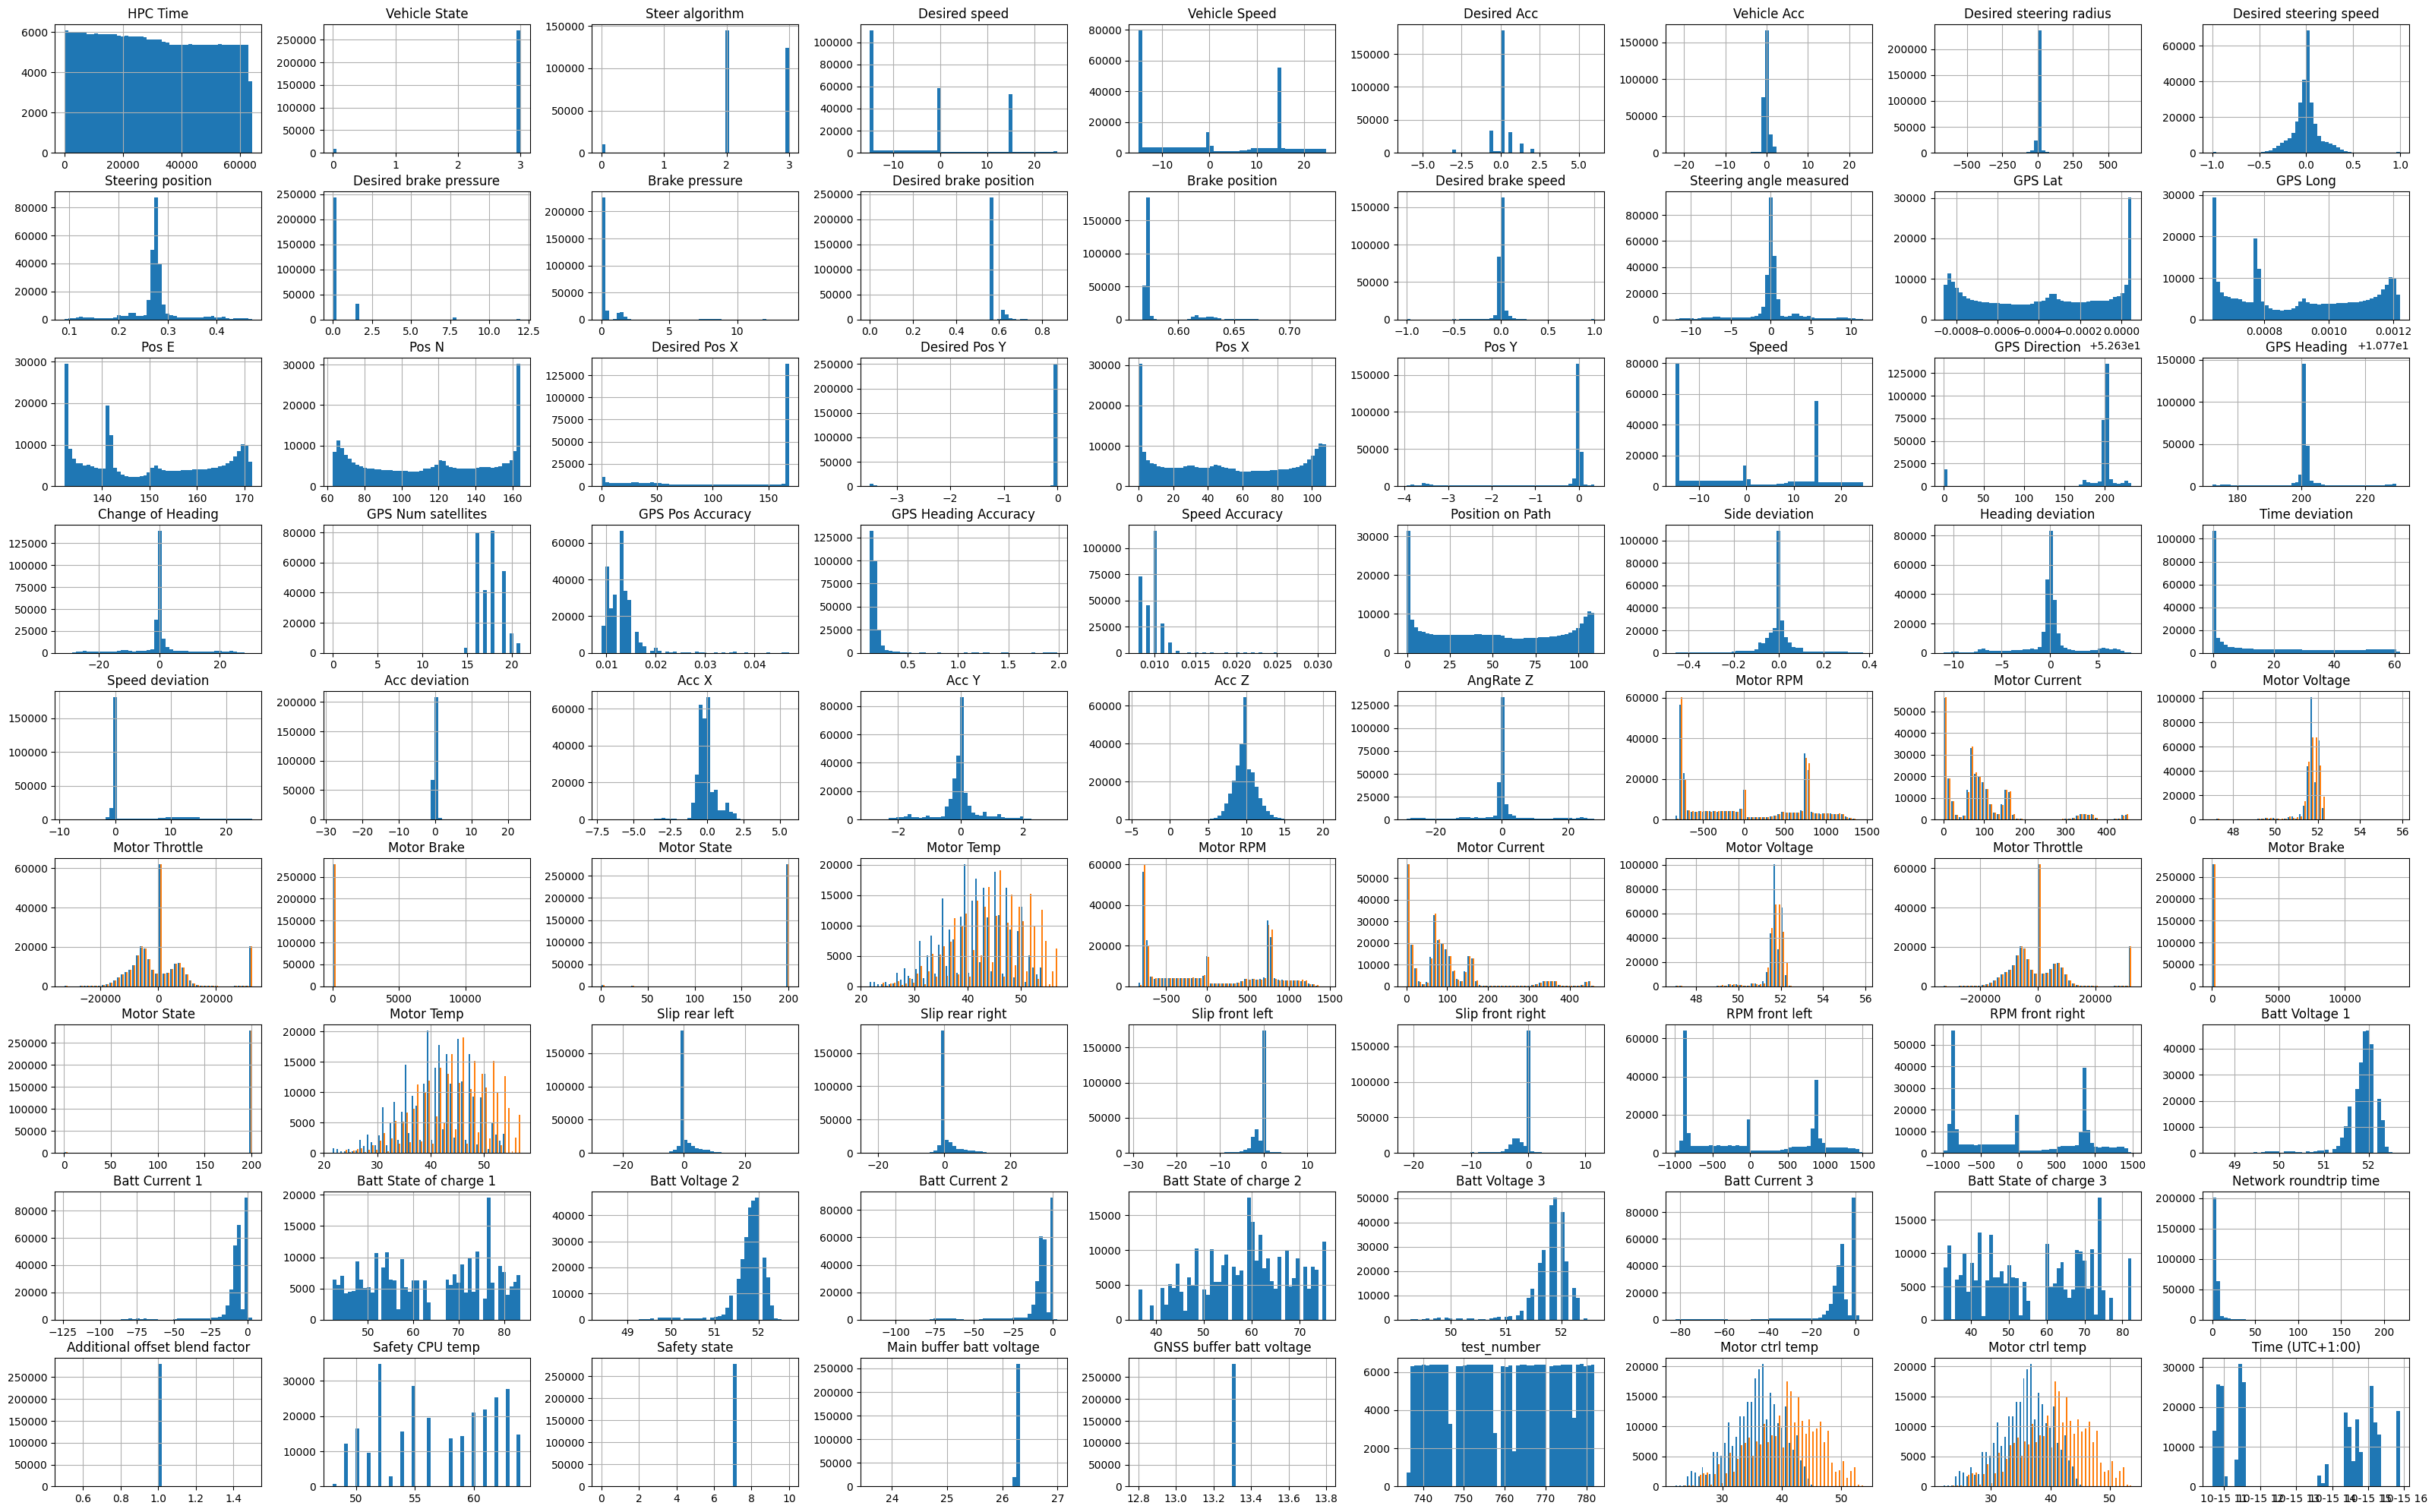

In [14]:
df.hist(bins=50,figsize=(40,25))
plt.show()

### **Adding Target Column Based on UFO_test_combined**

To simplify since this is a Mulit-class classification problem and improve the readability of the data and building model, we introduce a **target column** called `UFO_test_combined`, which assigns values based on specific test number ranges. The mapping of these values is as follows:

- **`UFO_test_combined = 0`**: UFO OK (Tests `UFO1_736` to `UFO1_747`)  
- **`UFO_test_combined = 1`**: Flat Tire Rear Left (Tests `UFO1_748` to `UFO1_757`)  
- **`UFO_test_combined = -1`**: Fehlversuche (Tests `UFO1_758` and `UFO1_759`)  
- **`UFO_test_combined = 2`**: Flat Tire Rear Right (Tests `UFO1_760` to `UFO1_770`)  
- **`UFO_test_combined = 3`**: Flat Tire Rear Right, Strong Flat Tire Rear Left (Tests `UFO1_771` to `UFO1_782`)  

This categorization helps in streamlining the analysis and enhances the interpretability of the dataset.

In [15]:
# Reset the index
df.reset_index(drop=True, inplace=True)
# Drop rows where test_number is 736
df = df[df['test_number'] != 736]

In [16]:
# Define the ranges for each condition with corresponding integer values for target
test_number_ranges = {
    0: (737, 747),  # test_ok
    1: (748, 757),  # slight flat_tire_rear_left
    2: (760, 770),  # slight flat_tire_rear_right
    3: (771, 782)   # severe_flat_rear_left_slight_flat_rear_right
}

# Function to assign integer values based on test_number
def assign_condition(test_number):
    for condition, (start, end) in test_number_ranges.items():
        if start <= test_number <= end:
            return condition  # Return the condition number
    return -1  # Default value for unknown or excluded cases

# Create the new column in the DataFrame
df['target'] = df['test_number'].apply(assign_condition)


In [18]:
# Check unique values in the target column
unique_target_values = df['target'].unique()
print(f"Unique values in target column: {unique_target_values}")

Unique values in target column: [ 0  1 -1  2  3]


# **Filtering Failure Tests**
Tests with -1 are identified as failure tests. These are being filtered out to ensure the dataset focuses on valid and relevant entries for analysis.

In [21]:
df_filtered = df[df['target'] != -1]

# **Selected Features for Tires Predictive Problem**

Based on research and relevance to the problem statement, the following features have been identified as having high potential to solve the predictive problem related to tire performance:

In [19]:
# List of highly relevant features for flat tire prediction (as per your request)
relevant_features = [
    'HPC Time', 'Slip rear left', 'Slip rear right', 'Slip front left', 'Slip front right',
    'RPM front left', 'RPM front right', 'Speed', 'Vehicle Speed', 'Acc X',
    'Acc Y', 'Acc Z', 'Side deviation', 'Speed deviation', 'Heading deviation',
    'Time deviation', 'Desired brake speed', 'Brake pressure', 'Brake position','test_number',
    'Desired brake position',  'Steering angle measured',
    'Steering position','target'
]

In [22]:
# Create a new dataframe with only the relevant features
df_relevant = df_filtered[relevant_features]
df_relevant.reset_index(drop=True, inplace=True) # Droping the index column

### Visualization of Selected Features
The graphs plotted below provide a detailed visualization of the selected features. These plots help to:

- Understand the distribution of target and behavior of each feature.

C:\Users\thoma\AppData\Local\Temp\ipykernel_3456\2524613440.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df_relevant, palette='Set2')  # Use the filtered DataFrame


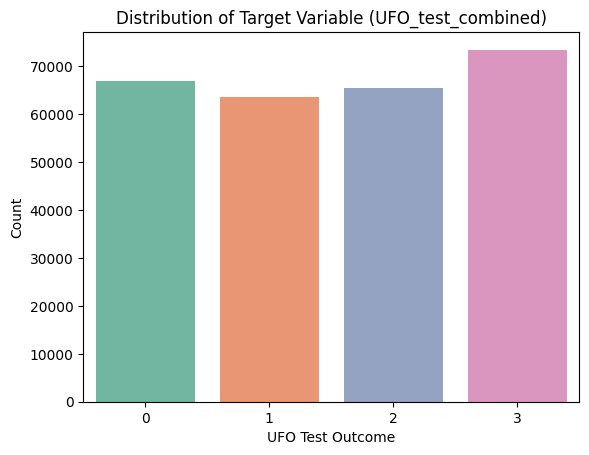

In [23]:
# Plotting the distribution of the target variable

sns.countplot(x='target', data=df_relevant, palette='Set2')  # Use the filtered DataFrame
plt.title('Distribution of Target Variable (UFO_test_combined)')
plt.xlabel('UFO Test Outcome')
plt.ylabel('Count')
plt.show()


### Sensor Characteristics and Relevance

To effectively detect flat tires or predict tire conditions, the following sensor characteristics are identified as most relevant:

1. **Tire-Specific Parameters**  
   - **Slip Rear Left / Rear Right**: Tracks the traction or slippage of the tires, providing critical insights for flat tire detection.

2. **Vehicle Dynamics**  
   - **Acceleration (Acc X, Acc Y, Acc Z)**:  
     - Lateral (Y) and Vertical (Z) acceleration changes can indicate vibrations or instability caused by tire conditions.  
     - Overall acceleration dynamics help assess vehicle stability and motion.  



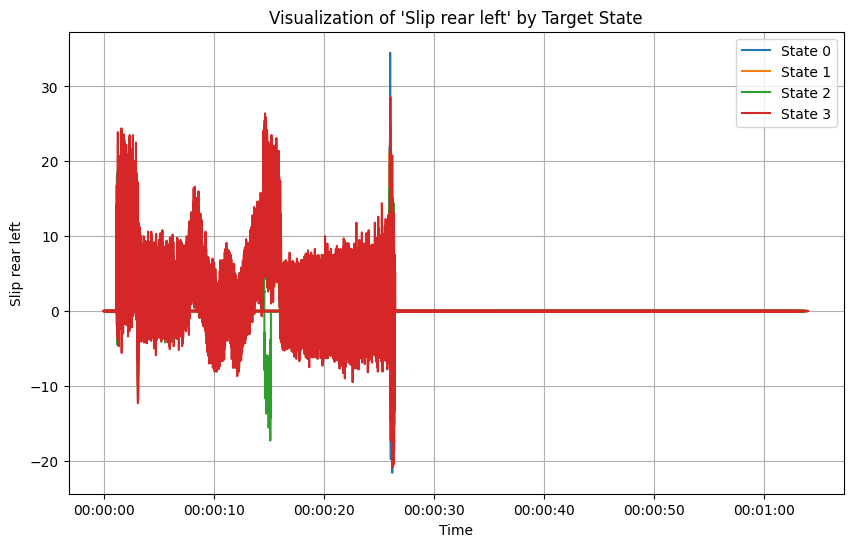

In [24]:


# Filter the DataFrame to include only necessary columns
df_filtered = df_relevant[['HPC Time', 'Slip rear left', 'target']].copy()

# Convert 'HPC Time [msec]' to datetime
df_filtered.loc[:, 'time'] = pd.to_datetime(df_relevant['HPC Time'], unit='ms')

# Choose a feature to visualize
feature_to_plot = 'Slip rear left'

# Plot feature values for each target class
plt.figure(figsize=(10, 6))

for state in df_filtered['target'].unique():
    state_data = df_filtered[df_filtered['target'] == state]
    plt.plot(state_data['time'], state_data[feature_to_plot], label=f"State {state}")

# Customize the plot
plt.xlabel('Time')
plt.ylabel(feature_to_plot)
plt.title(f"Visualization of '{feature_to_plot}' by Target State")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


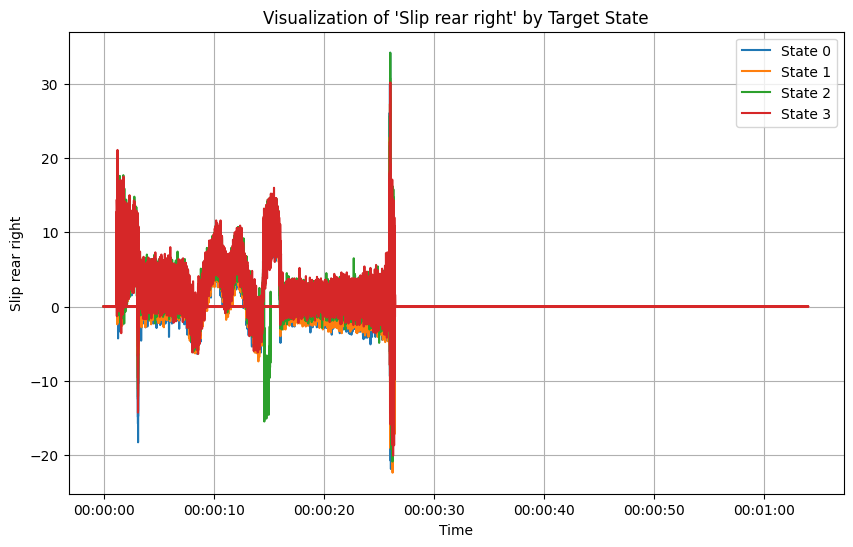

In [25]:


# Filter the DataFrame to include only necessary columns
df_filtered = df_relevant[['HPC Time', 'Slip rear right', 'target']].copy()

# Convert 'HPC Time [msec]' to datetime
df_filtered.loc[:, 'time'] = pd.to_datetime(df_relevant['HPC Time'], unit='ms')

# Choose a feature to visualize
feature_to_plot = 'Slip rear right'

# Plot feature values for each target class
plt.figure(figsize=(10, 6))

for state in df_filtered['target'].unique():
    state_data = df_filtered[df_filtered['target'] == state]
    plt.plot(state_data['time'], state_data[feature_to_plot], label=f"State {state}")

# Customize the plot
plt.xlabel('Time')
plt.ylabel(feature_to_plot)
plt.title(f"Visualization of '{feature_to_plot}' by Target State")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [23]:
df_relevant_combinations = df_relevant.copy()

C:\Users\thoma\AppData\Local\Temp\ipykernel_18132\4289566643.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['time'] = pd.to_datetime(df_filtered['HPC Time'], unit='ms')


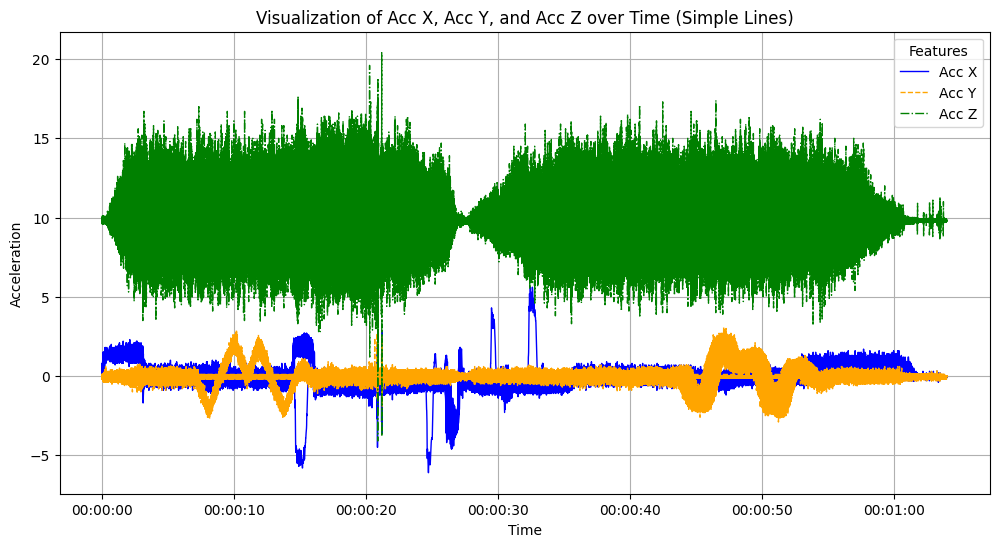

In [24]:

# Filter the required columns
df_filtered = df[['HPC Time', 'Acc X', 'Acc Y', 'Acc Z', 'target']]

# Convert 'HPC Time [msec]' to datetime format
df_filtered['time'] = pd.to_datetime(df_filtered['HPC Time'], unit='ms')

# Initialize the plot
plt.figure(figsize=(12, 6))

# Plot each feature with simple lines
plt.plot(df_filtered['time'], df_filtered['Acc X'], label='Acc X', linestyle='-', linewidth=1, color='blue')
plt.plot(df_filtered['time'], df_filtered['Acc Y'], label='Acc Y', linestyle='--', linewidth=1, color='orange')
plt.plot(df_filtered['time'], df_filtered['Acc Z'], label='Acc Z', linestyle='-.', linewidth=1, color='green')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Visualization of Acc X, Acc Y, and Acc Z over Time (Simple Lines)')
plt.legend(title="Features")
plt.grid(True)

# Show the plot
plt.show()


#### Acceleration Analysis and Key Observations

1. **Acc Z (Green)**  
   - Dominates the plot with high variability.  
   - Likely influenced by gravity and vertical motion, such as road bumps or vibrations.  

2. **Acc X (Blue)**  
   - Shows moderate fluctuations.  
   - Reflects forward/backward motion or minor vibrations.  

3. **Acc Y (Orange)**  
   - Exhibits relatively low variability.  
   - Indicates minimal lateral movement.  

**Key Events**  
- Sharp peaks in Acc X or Acc Z may signify braking, bumps, or abrupt changes in motion.  

**Potential Insights**  
- Patterns in Acc Z could correlate with specific events, such as flat tire detection or road irregularities.  
________________________________________________________________________________________________

### **Combinations of features**

1. **Avg_Slip Calculation**  
   - Averages slip measurements to provide an overall indicator of tire traction.  

2. **Acceleration Magnitude**  
   - Combines Acc X, Acc Y, and Acc Z to represent the total acceleration experienced by the vehicle.  

3. **Slip_Acc_Interaction**  
   - Integrates the average slip and acceleration magnitude to capture interaction effects, such as traction loss during acceleration or deceleration.  


In [25]:


# Combination 1: Combine Slip values into a single feature (e.g., average slip)
df_relevant_combinations['Avg_Slip'] = (df_relevant_combinations['Slip rear left'] + df_relevant_combinations['Slip rear right']) / 2

# Combination 2: Calculate the magnitude of acceleration (Euclidean norm)
df_relevant_combinations['Acc_Magnitude'] = (df_relevant_combinations['Acc X']**2 + df_relevant_combinations['Acc Y']**2 + df_relevant_combinations['Acc Z']**0.5)

# Combination 3: Create an interaction feature combining Avg_Slip and Acc_Magnitude
df_relevant_combinations['Slip_Acc_Interaction'] = df_relevant_combinations['Avg_Slip'] * df_relevant_combinations['Acc_Magnitude']

# Display the new features
print(df_relevant_combinations[['Avg_Slip', 'Acc_Magnitude', 'Slip_Acc_Interaction']].head(1000))


     Avg_Slip  Acc_Magnitude  Slip_Acc_Interaction
0        0.00       3.180495              0.000000
1        0.00       3.150495              0.000000
2        0.00       3.180495              0.000000
3        0.00       3.180495              0.000000
4        0.00       3.316427              0.000000
..        ...            ...                   ...
995      2.60       5.668613             14.738393
996      4.05       6.062278             24.552225
997      2.85       6.794102             19.363190
998      2.55       7.199576             18.358919
999      1.35       6.909361              9.327638

[1000 rows x 3 columns]


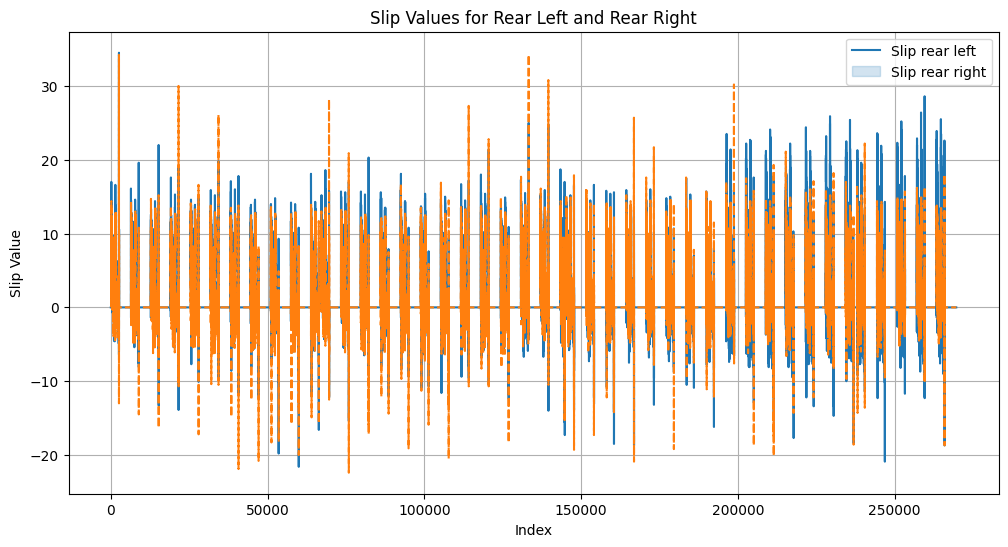

In [46]:
# Visualize the Slip values
plt.figure(figsize=(12, 6))

# Plotting Slip rear left and Slip rear right
sns.lineplot(data=df_relevant_combinations[['Slip rear left', 'Slip rear right']], palette='tab10')
plt.title('Slip Values for Rear Left and Rear Right')
plt.xlabel('Index')
plt.ylabel('Slip Value')
plt.legend(['Slip rear left', 'Slip rear right'])
plt.grid(True)
plt.show()

# **Data Modeling**

The data modeling phase involves:

1. **Data Preparation**: Cleaning, scaling, and normalizing features.  
2. **Feature Engineering**: Using key features (e.g., Avg_Slip, Acceleration Magnitude) and creating new interactions.  
3. **Model Selection**: Testing algorithms like LSTM and CNN for performance.  
4. **Training and Validation**: Splitting data, training model.  
5. **Evaluation**: Confusion Matrix. Ensuring the model reliably predicts tire conditions for effective maintenance.

This ensures a robust and accurate predictive model.


In [26]:
# Drop 'target' and 'test_number' from the feature set
df_relevant_features = df_relevant.drop(columns=['target', 'test_number'])
target = df_relevant['target']  # Store target column separately

# Check the target distribution
print(target.value_counts())


target
3    73501
0    66983
2    65466
1    63667
Name: count, dtype: int64


### **Grouping Test Drive Data for Time Series Modeling**
To prepare data for time series models like LSTM, test drive data is grouped by `test_number`. This ensures sequential data is organized chronologically, maintaining temporal relationships crucial for predictive modeling.


In [27]:
# Group the data by 'test_number' to ensure sequences belong to the same test
df_grouped = df_relevant.groupby('test_number')
# Check if the grouping looks correct
print(df_grouped.size())


test_number
737    6300
738    6348
739    6350
740    6371
741    6364
742    6385
743    6400
744    6402
745    6396
746    6401
747    3266
748    6298
749    6324
750    6364
751    6383
752    6387
753    6393
754    6397
755    6366
756    6367
757    6388
760    6283
761    6330
762    1842
763    6360
764    6379
765    6386
766    6358
767    6364
768    6382
769    6393
770    6389
771    6307
772    6349
773    6356
774    6381
775    6380
776    6371
777    3577
778    6383
779    6407
780    6290
781    6332
782    6368
dtype: int64


_______________________________________________________________________________________

### Balancing the data which was imbalanced to showcase how this is internally happening.

In [35]:
sequences = []
labels = []

for test_number, group in df_filtered.groupby('test_number'):
    # Extract features as sequences
    group_features = group[relevant_features].values
    # Extract corresponding label (assuming one label per test_number)
    group_label = group['target'].iloc[0]
    sequences.append(group_features)
    labels.append(group_label)

print(f"Number of sequences created: {len(sequences)}")


Number of sequences created: 44


In [37]:

from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Determine the maximum sequence length
max_sequence_length = max(len(seq) for seq in sequences)

# Pad sequences to have the same length
sequences_padded = pad_sequences(sequences, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

# Convert labels to NumPy array
labels = np.array(labels)

print(f"Padded sequences shape: {sequences_padded.shape}")


Padded sequences shape: (44, 6407, 24)


In [40]:

from sklearn.utils import resample
# Check the distribution of the target variable
class_distribution = pd.Series(labels).value_counts()
print("Original Class Distribution:")
print(class_distribution)

# Create a DataFrame combining sequences and labels for easier manipulation
df_balanced = pd.DataFrame(
    sequences_padded.reshape(sequences_padded.shape[0], -1),  # Flatten sequences
    columns=[f'feature_{i}' for i in range(sequences_padded.shape[1] * sequences_padded.shape[2])]
)
df_balanced['target'] = labels  # Add target column

# Ensure every class has at least 1 sample
balanced_df = pd.DataFrame()
for label in df_balanced['target'].unique():
    class_samples = df_balanced[df_balanced['target'] == label]
    if len(class_samples) < 1:
        print(f"Warning: Class {label} has insufficient samples!")
        continue
    # Add one sample per class (minimum representation)
    class_min = class_samples.sample(n=1, random_state=42)
    balanced_df = pd.concat([balanced_df, class_min])

# Now balance all classes to 10 samples each
target_samples_per_class = 10

# Loop through classes to balance the dataset
for label in df_balanced['target'].unique():
    class_samples = df_balanced[df_balanced['target'] == label]
    if len(class_samples) > target_samples_per_class:
        # Undersample majority class
        class_balanced = class_samples.sample(n=target_samples_per_class - 1, random_state=42)
    else:
        # Oversample minority class
        class_balanced = resample(
            class_samples,
            replace=True,
            n_samples=target_samples_per_class - 1,
            random_state=42
        )
    balanced_df = pd.concat([balanced_df, class_balanced])

# Shuffle the balanced data
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate sequences and labels
sequences_padded_balanced = balanced_df.drop(columns=['target']).values.reshape(-1, sequences_padded.shape[1], sequences_padded.shape[2])
labels_balanced = balanced_df['target'].values

# Print results
print(f"Balanced Class Distribution: {pd.Series(labels_balanced).value_counts()}")
print(f"Balanced dataset shape: {sequences_padded_balanced.shape}")


Original Class Distribution:
3    12
0    11
2    11
1    10
Name: count, dtype: int64
Balanced Class Distribution: 1    10
2    10
0    10
3    10
Name: count, dtype: int64
Balanced dataset shape: (40, 6407, 24)


__________________________________________________________________________________________
## **Balancing the Data for Time Series Prediction**
Instead of traditional oversampling/undersampling techniques above, I used a time-series-specific approach to prepare and balance the dataset. The process includes creating sequences from the data and splitting it into training and testing sets while preserving the temporal
.
### **Why This Approach**?

This approach maintains temporal order, captures time-dependent patterns, avoids data leakage, and is tailored for time-series models like LSTM to ensure accurate predictions.)

##  Normalize the Data

In [31]:
from sklearn.preprocessing import StandardScaler

# Initialize a list to store the normalized data
scaled_data = []

# Loop through each test group and normalize the features
for _, group in df_grouped:
    df_features = group.drop(columns=['target', 'test_number'])  # Drop target and test_number columns
    scaler = StandardScaler()
    scaled_group = scaler.fit_transform(df_features)  # Normalize the features
    scaled_data.append(np.column_stack([scaled_group, group['target'].values]))  # Include the target column

# Combine the scaled data from all tests into a single DataFrame
df_scaled = np.vstack(scaled_data)

# Check the shape of the processed data
print(df_scaled.shape)


(269617, 23)


### Creating Sequences for Time Series Prediction
Instead of padding, sequences can be created dynamically for time series prediction. This method preserves the temporal order and context of the data.

In [32]:


# Function to create dataset for time series prediction
def create_dataset(features, target, time_step=1):
    X, y = [], []
    for i in range(len(features) - time_step):
        X.append(features[i:i + time_step, :-1])  # All columns as features (exclude target)
        y.append(target[i + time_step])  # Target variable at the corresponding time step
    return np.array(X), np.array(y)

# Create the dataset (combine features and target columns)
X, y = create_dataset(df_scaled[:, :-1], df_scaled[:, -1], time_step=10)

# Train-test split (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshaping data for LSTM model: (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])


### Building the LSTM Model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the LSTM model
model = Sequential()

# LSTM Layer 1
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# LSTM Layer 2
model.add(LSTM(units=32))
model.add(Dropout(0.2))

# Output Layer (Softmax for multi-class classification)
model.add(Dense(units=len(np.unique(y)), activation='softmax'))  # Number of classes

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


C:\Users\thoma\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Training above model using Activation function SOFTMAX

In [61]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/10
3371/3371 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 47s 12ms/step - accuracy: 0.5869 - loss: 0.7886 - val_accuracy: 0.8319 - val_loss: 0.3742
Epoch 2/10
3371/3371 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 49s 14ms/step - accuracy: 0.8168 - loss: 0.3959 - val_accuracy: 0.8423 - val_loss: 0.3614
Epoch 3/10
3371/3371 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 42s 12ms/step - accuracy: 0.8548 - loss: 0.3295 - val_accuracy: 0.9001 - val_loss: 0.2374
Epoch 4/10
3371/3371 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 12ms/step - accuracy: 0.8833 - loss: 0.2669 - val_accuracy: 0.9033 - val_loss: 0.2256
Epoch 5/10
3371/3371 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 43s 13ms/step - accuracy: 0.9005 - loss: 0.2325 - val_accuracy: 0.9211 - val_loss: 0.1880
Epoch 6/10
3371/3371 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 12ms/step - accuracy: 0.9120 - loss: 0.2074 - val_accu

 ### Evaluate the model on the test set

In [63]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


1686/1686 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 4ms/step - accuracy: 0.9607 - loss: 0.0973
Loss: 0.09772282838821411, Accuracy: 0.9607396125793457


### Model Results

The model demonstrated excellent performance with the following metrics:

- **Accuracy**: 96.07%  
  This indicates that the model correctly predicted the target class in 96.07% of cases, reflecting high reliability.

- **Loss**: 0.0973  
  A low loss value signifies that the model's predictions are closely aligned with the actual target values.

These results highlight the model's effectiveness in solving the predictive task, making it suitable for deployment or further fine-tuning.


### # Predict on test data

In [64]:

predictions = model.predict(X_test)

# Convert predictions to the actual class labels
predicted_classes = np.argmax(predictions, axis=1)

# Compare with the actual target values
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_classes))


1686/1686 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 5ms/step
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94     13364
         1.0       0.96      0.91      0.93     12597
         2.0       0.99      0.98      0.98     13100
         3.0       0.98      0.99      0.98     14861

    accuracy                           0.96     53922
   macro avg       0.96      0.96      0.96     53922
weighted avg       0.96      0.96      0.96     53922



### Model Evaluation on Test Data

The model's performance on the test data is summarized below, showcasing its precision, recall, and F1-score for each class:

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| **0.0** | 0.92      | 0.96   | 0.94     | 13,364  |
| **1.0** | 0.96      | 0.91   | 0.93     | 12,597  |
| **2.0** | 0.99      | 0.98   | 0.98     | 13,100  |
| **3.0** | 0.98      | 0.99   | 0.98     | 14,861  |

**Overall Metrics:**
- **Accuracy**: 96%  
- **Macro Average**: Precision = 0.96, Recall = 0.96, F1-Score = 0.96  
- **Weighted Average**: Precision = 0.96, Recall = 0.96, F1-Score = 0.96  

These results indicate consistent and robust performance across all classes, making the model highly reliable for predictive tasks.


### # Generate confusion matrix

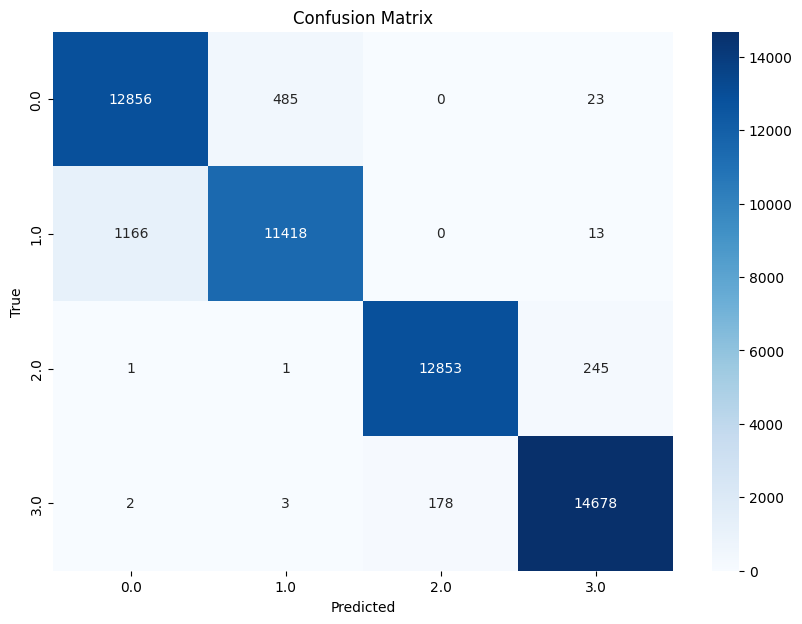

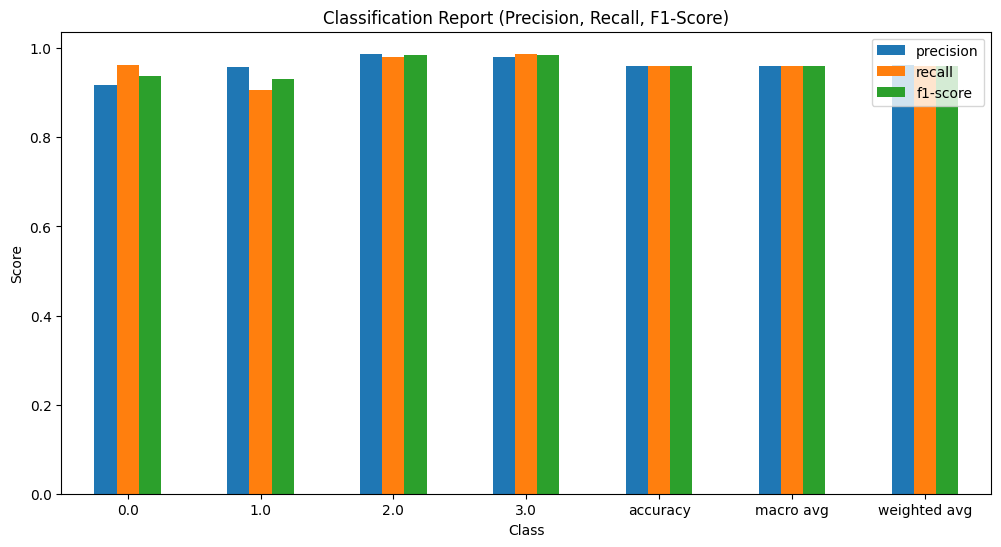

In [65]:
# Generate confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, predicted_classes)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Optionally, plot the classification report
report = classification_report(y_test, predicted_classes, output_dict=True)

# Prepare data for plotting (extract precision, recall, and f1-score for each class)
report_df = pd.DataFrame(report).transpose()

# Plot the metrics
report_df.drop(columns=['support'], inplace=True)  # Drop support column
report_df.plot(kind='bar', figsize=(12, 6))
plt.title('Classification Report (Precision, Recall, F1-Score)')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.show()

### Results Summary

#### **Confusion Matrix**
The model performs exceptionally well across all classes:
- **Class 0.0 & 1.0**: High accuracy with minimal misclassifications, primarily between neighboring classes.
- **Class 2.0 & 3.0**: Outstanding precision and recall, with very few errors.

#### **Classification Report**
- Precision, recall, and F1-scores exceed 90% across all classes.
- Overall accuracy: **96%**, reflecting balanced and reliable predictions.

The model is highly effective and ready for deployment in predictive tasks.

## Model 2 : CNN - Same process until grouping

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential()

# 1D Convolutional Layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# Flatten the output to feed into a Dense layer
model.add(Flatten())

# Dense Layer
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))

# Output Layer (Softmax for multi-class classification)
model.add(Dense(units=len(np.unique(y)), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


C:\Users\thoma\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [67]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/20
3371/3371 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 16s 4ms/step - accuracy: 0.4922 - loss: 0.9868 - val_accuracy: 0.8019 - val_loss: 0.4249
Epoch 2/20
3371/3371 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 4ms/step - accuracy: 0.7637 - loss: 0.4757 - val_accuracy: 0.8279 - val_loss: 0.3573
Epoch 3/20
3371/3371 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 4ms/step - accuracy: 0.8102 - loss: 0.3990 - val_accuracy: 0.8492 - val_loss: 0.3138
Epoch 4/20
3371/3371 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 4ms/step - accuracy: 0.8291 - loss: 0.3637 - val_accuracy: 0.8717 - val_loss: 0.2792
Epoch 5/20
3371/3371 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 15s 4ms/step - accuracy: 0.8435 - loss: 0.3361 - val_accuracy: 0.8753 - val_loss: 0.2726
Epoch 6/20
3371/3371 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 4ms/step - accuracy: 0.8509 - loss: 0.3222 - val_accuracy: 

In [68]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


1686/1686 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 2ms/step - accuracy: 0.9185 - loss: 0.1980
Loss: 0.19603507220745087, Accuracy: 0.9203107953071594


In [69]:
# Predict on test data
predictions = model.predict(X_test)

# Convert predictions to the actual class labels
predicted_classes = np.argmax(predictions, axis=1)

# Compare with the actual target values
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_classes))


1686/1686 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 2ms/step
              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88     13364
         1.0       0.89      0.84      0.86     12597
         2.0       0.97      0.97      0.97     13100
         3.0       0.97      0.97      0.97     14861

    accuracy                           0.92     53922
   macro avg       0.92      0.92      0.92     53922
weighted avg       0.92      0.92      0.92     53922



1686/1686 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 2ms/step


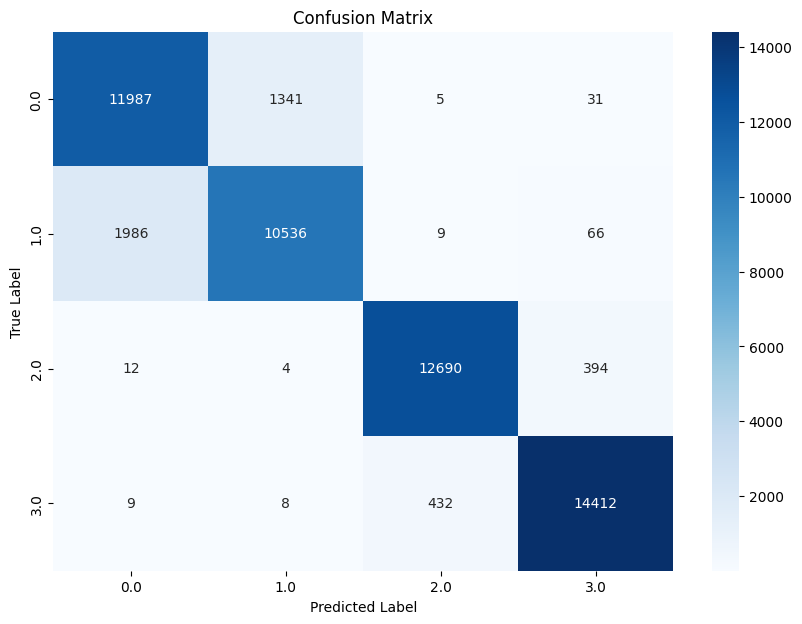

In [70]:
# Predict on test data
predictions = model.predict(X_test)

# Convert predictions to the actual class labels
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Comparison, Conclusion, and Recommendations

#### **Comparison**  
- **CNN**: 92% accuracy, efficient and faster, best for spatial features.  
- **LSTM**: Handles temporal dependencies well but slower and complex.  

#### **Conclusion**  
CNN is preferred for its simplicity unless deep time-based patterns are critical.

#### **Recommendations**  
1. Use CNN for fast, high-accuracy predictions.  
2. Optimize LSTM for time-dependent problems.  
3. Consider a hybrid CNN-LSTM approach for combined spatial-temporal tasks.
____________________________________________________________________________________

# THE END